# House price prediction for Denver Dataset

In this case (Part II), there are two main tasks:

- First, you will need to split the train data into train and validate data and tune the model hyperparameters to choose the best model. Submit the predicted prices for test data to Kaggle to compete for Prof. X's Prize!

- Then you will examine the profit of the iBuyer business model based on the predicted price on the valid data.






You need to submit a report in pdf format containing the following material on canvas site:

1.   A plot of the training errors and validation errors over epochs for a base multilayer perceptron model with 2 hidden layers of sizes 256 and 128.

2.   A plot of the training errors and validation errors over epochs for a  multilayer perceptron model with 4 hidden layers of sizes 512, 256, 128, 64.

3.  A plot of the training errors and validation errors over epochs for a  multilayer perceptron model with 4 hidden layers of sizes 512, 256, 128, 64
and norm regularization.

4. A plot of the training errors and validation errors over epochs for a  multilayer perceptron model with 4 hidden layers of sizes 512, 256, 128, 64
and norm regularization and dropout layers.

5. A table listing all the model hyperparameters that you have tried with the corresponding validation errors that you found.

6. Your profit analysis of the the iBuyer business model based on the predicted price on the valid data and answers to the four questions therein.


You also need to submit on canvas site:

- The complete Juyputer notebook containing all your Pytorch code with explanations, along with a Markdown text explaining different parts if needed.
-  A checkpoint.pth file containing all the necessary information to retrieve your best model and predictions.



---
## Data Loading and Visualize Data

The train data and test data are available on Kaggle website.
You can first download them, then upload them to the google colab, and then read the data using pandas.

In [2]:
import pandas as pd  # Importing pandas, which is a library for data manipulation and analysis
#TODO: Read the datasets
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
# Display the train dataframe
print(train_df.shape)
print(train_df.columns)

(11581, 17)
Index(['ID', 'NBHD', 'PROP_CLASS', 'LIVING_SQFT', 'FBSMT_SQFT', 'BSMT_AREA',
       'LAND_SQFT', 'GRD_AREA', 'BLDG_AGE', 'RM_AGE', 'BED_RMS', 'FULL_B',
       'HLF_B', 'STORY', 'STYLE_CN', 'UNITS', 'SALE_PRICE'],
      dtype='object')


In [4]:
# Display the test dataframe
print(test_df.shape)
print(test_df.columns)

(4964, 16)
Index(['ID', 'NBHD', 'PROP_CLASS', 'LIVING_SQFT', 'FBSMT_SQFT', 'BSMT_AREA',
       'LAND_SQFT', 'GRD_AREA', 'BLDG_AGE', 'RM_AGE', 'BED_RMS', 'FULL_B',
       'HLF_B', 'STORY', 'STYLE_CN', 'UNITS'],
      dtype='object')


As you can see, we have 11581 training samples and 4964 test samples, each with 16 features. The training samples contain the sale_prices, which are the labels. The test samples do not contain the sale_prices, which we will predict by building a MLP model.


### Visualization of SALE PRICES

Let's take a closer look at the sale prices in the train data.

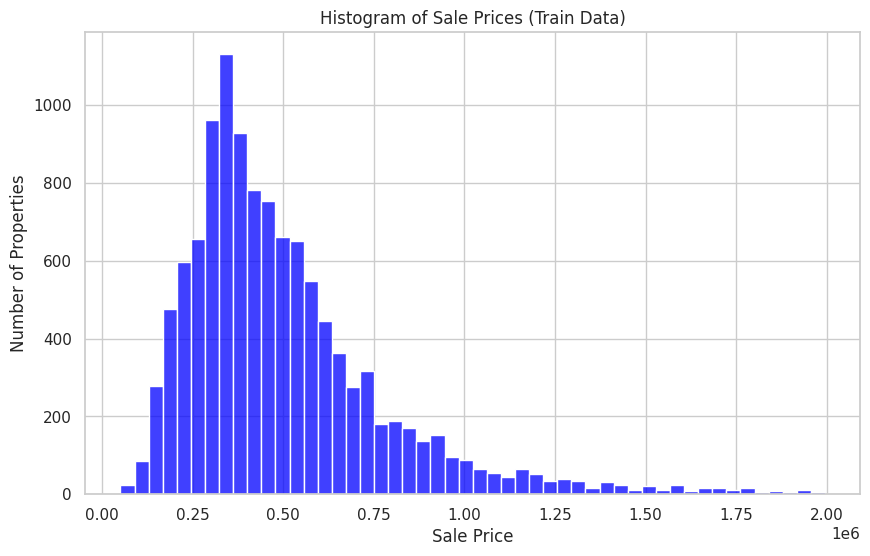

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt  # Importing matplotlib's pyplot, it provides a MATLAB-like interface for making plots and charts

# Set the style
sns.set(style="whitegrid")

# Create a histogram
plt.figure(figsize=(10, 6))
sns.histplot(train_df['SALE_PRICE'], bins=50, color='blue')
plt.title('Histogram of Sale Prices (Train Data)')
plt.xlabel('Sale Price')
plt.ylabel('Number of Properties')
plt.show()

Check the minimum and maximum sale_price in train data.

In [6]:
print(train_df['SALE_PRICE'].min())
print(train_df['SALE_PRICE'].max())
print(train_df['SALE_PRICE'].median())

51000
1995000
431000.0


We see that the sale_price has a wide range from 50K to 2 million, with the median price 431K.

### Visualization of Correlation

We can also compute and visualize the correlation matrix.

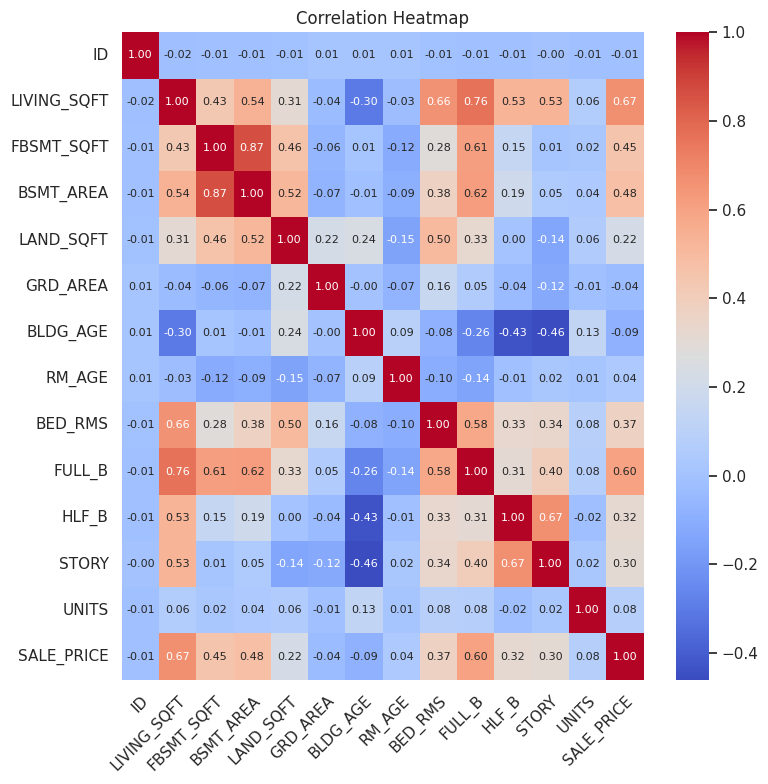

<Figure size 640x480 with 0 Axes>

In [7]:

# Select only numeric columns for correlation matrix computation
numeric_train_df = train_df.select_dtypes(include=[float, int])

# Compute the correlation matrix:
correlation_matrix = numeric_train_df.corr()

# 1. Increase the figure size for clarity
plt.figure(figsize=(8, 8))

# 2. Use a heatmap with annotations, a color map, and specific formatting for the annotations
ax = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={'size': 8})

# 3. Rotate the x-axis labels for better visibility
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Rotate the y-axis labels
plt.setp(ax.get_yticklabels(), rotation=0)

# 4. Title and display
plt.title('Correlation Heatmap')
plt.tight_layout()  # This can help if any labels are still being cut off
plt.show()

# 5. Optionally save the figure with high resolution
plt.savefig("heatmap.png", dpi=300)

We can see that the Sale_Price has high correlation with Living_SQFT and number of Full Bathrooms.

### Distribution of houses over different NBHD

In [8]:
# Compute the number of houses per neighborhood
House_by_NBHD = train_df['NBHD'].value_counts()
print(House_by_NBHD )

NBHD
CENTRAL PARK                    1049
GATEWAY / GREEN VALLEY RANCH     937
UNION STATION                    369
HAMPDEN                          346
WINDSOR                          316
                                ... 
VALVERDE                          22
GLOBEVILLE                        20
SUN VALLEY                         8
CORY - MERRILL                     4
AURARIA                            1
Name: count, Length: 75, dtype: int64


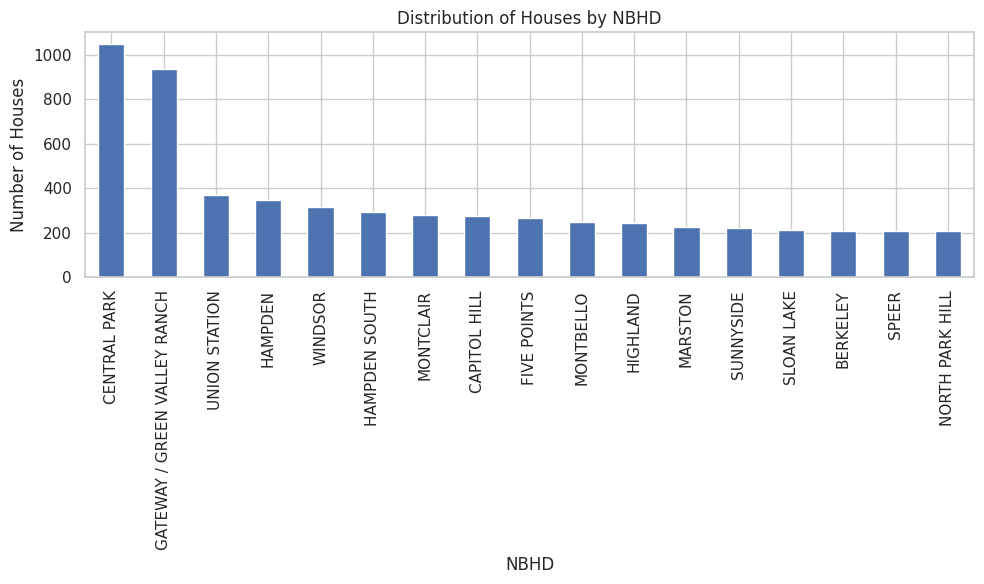

In [9]:
# Filtering ZIP codes that appear more than once
filtered_House_by_NBHD = House_by_NBHD[House_by_NBHD > 200]
filtered_House_by_NBHD.plot(kind='bar', figsize=(10,6))
plt.title('Distribution of Houses by NBHD')
plt.ylabel('Number of Houses')
plt.xlabel('NBHD')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability, if necessary
plt.tight_layout()  # Ensure everything fits without overlapping
plt.show()


---
## Data Preparation

The first step when building a neural network model is getting your data into the proper form to feed into the network.

- Train labels: We need to extract the sale prices from the train data as train labels. Since the house prices can take very large values, to make training fast it is helpful to define the train labels as the sale prices divided by a normalization factor.

- **Handing non-numeric features**: Some of the house features are non-numeric. We will learn about how to process categorical data in the upcoming lectures. For now, you can  remove those non-numeric features and only train over the numeric features.

- **Feature standardization**: When predicting house prices, you started from features that took a variety of ranges—some features had small floating-point values, and others had fairly large integer values. The model might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice for dealing with such data is to do feature-wise normalization: for each feature in the input data (a column in the input dataframe), we subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has
a unit standard deviation. Note that here we combine the feature vectors in the train and test data. In this way, the train and test data go through the same normalization.

- **Handling missing values**: There may exist some entries with missing values. After the feature standardization, we can impute the missing values with zeros.

In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4964 entries, 0 to 4963
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           4964 non-null   int64  
 1   NBHD         4964 non-null   object 
 2   PROP_CLASS   4964 non-null   object 
 3   LIVING_SQFT  4964 non-null   int64  
 4   FBSMT_SQFT   4964 non-null   int64  
 5   BSMT_AREA    4964 non-null   int64  
 6   LAND_SQFT    4964 non-null   int64  
 7   GRD_AREA     4964 non-null   int64  
 8   BLDG_AGE     4964 non-null   int64  
 9   RM_AGE       2623 non-null   float64
 10  BED_RMS      4964 non-null   float64
 11  FULL_B       4964 non-null   float64
 12  HLF_B        4964 non-null   int64  
 13  STORY        4964 non-null   float64
 14  STYLE_CN     4964 non-null   object 
 15  UNITS        4964 non-null   float64
dtypes: float64(5), int64(8), object(3)
memory usage: 620.6+ KB


We see that the sale_price in train data has a wide range from 50K to 2 million, with the median price 431K. We can divide the sale_price by 100K, so the normalized sale_price is between 0.5 and 20 in training data. Remember, when we output the predicted price for the test data, we need to multiply back the normalization factor.

In [11]:
#TODO: define labels for train data
normalization_factor=100000
train_labels = train_df['SALE_PRICE']/normalization_factor
train_df.drop('SALE_PRICE', axis=1, inplace=True) # drop the sale_prices in features.

The inplace parameter, when set to True , allows you to drop the rows or columns without returning a new DataFrame. The issue arises when the drop function reorders the DataFrame, which can be problematic when the order of your data matters

Note that both the training samples and test samples contain an ID column, which is not informative for predicting the house price. Thus we will drop the ID column.

In [12]:
train_ID=train_df['ID']
test_ID=test_df['ID']
train_df.drop('ID', axis=1, inplace=True)
test_df.drop('ID', axis=1, inplace=True)

In [13]:
# Then we combine the feature vectors in the train data and test data
features=pd.concat(objs=[train_df,test_df],axis=0)

In [14]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16545 entries, 0 to 4963
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   NBHD         16545 non-null  object 
 1   PROP_CLASS   16545 non-null  object 
 2   LIVING_SQFT  16545 non-null  int64  
 3   FBSMT_SQFT   16545 non-null  int64  
 4   BSMT_AREA    16545 non-null  int64  
 5   LAND_SQFT    16545 non-null  int64  
 6   GRD_AREA     16545 non-null  int64  
 7   BLDG_AGE     16545 non-null  int64  
 8   RM_AGE       8705 non-null   float64
 9   BED_RMS      16545 non-null  float64
 10  FULL_B       16545 non-null  float64
 11  HLF_B        16545 non-null  int64  
 12  STORY        16545 non-null  float64
 13  STYLE_CN     16545 non-null  object 
 14  UNITS        16545 non-null  float64
dtypes: float64(5), int64(7), object(3)
memory usage: 2.0+ MB


We see that there are three non-numeric features, namely `NBHD`, `PROP_CLASS`, and `STYLE_CN`. We will apply one-hot encoding to those non-numeric features in our model; you could also simply drop these non-numeric features.

In [15]:
numeric_features = features.dtypes[features.dtypes != 'object'].index
non_numeric_features = features.dtypes[features.dtypes == 'object'].index
numeric_features, non_numeric_features

(Index(['LIVING_SQFT', 'FBSMT_SQFT', 'BSMT_AREA', 'LAND_SQFT', 'GRD_AREA',
        'BLDG_AGE', 'RM_AGE', 'BED_RMS', 'FULL_B', 'HLF_B', 'STORY', 'UNITS'],
       dtype='object'),
 Index(['NBHD', 'PROP_CLASS', 'STYLE_CN'], dtype='object'))

In [16]:
train_df.head()

,NBHD,PROP_CLASS,LIVING_SQFT,FBSMT_SQFT,BSMT_AREA,LAND_SQFT,GRD_AREA,BLDG_AGE,RM_AGE,BED_RMS,FULL_B,HLF_B,STORY,STYLE_CN,UNITS
0,MONTCLAIR,CONDOMINIUMS,928,0,0,0,0,60,4.0,2.0,2.0,0,1.0,END UNIT,1.0
1,HIGHLAND,SINGLE FAMILY RESIDENCE,2338,900,948,3125,0,6,NaN,3.0,4.0,1,3.0,END UNIT,1.0
2,ATHMAR PARK,SINGLE FAMILY RESIDENCE,999,757,807,8900,0,67,6.0,3.0,2.0,0,1.0,1 STORY,1.0
3,MONTCLAIR,SINGLE FAMILY RESIDENCE,876,0,0,6100,0,77,15.0,2.0,1.0,0,1.0,1 STORY,1.0
4,GATEWAY / GREEN VALLEY RANCH,SINGLE FAMILY RESIDENCE,1729,0,0,2160,0,1,NaN,3.0,2.0,1,2.0,MIDDLE UNIT,1.0


In [17]:
# If you want to drop the non-numeric features, you just set drop_non_numeric_features= True.
drop_non_numeric_features= False

if drop_non_numeric_features:
    features= features.drop(non_numeric_features, axis=1)
else:
    # One-hot encode categorical features
    features = pd.get_dummies(features, columns=non_numeric_features, dummy_na=True)

# Check for non-numeric columns
non_numeric_cols = features.select_dtypes(include=['object']).columns
if not non_numeric_cols.empty:
    raise ValueError(f"DataFrame contains non-numeric columns: {non_numeric_cols.tolist()}")

In [18]:
# Standardize numeric features
features[numeric_features] = features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))

In [19]:
# recheck the mean and std after standardization
features[numeric_features].mean(), features[numeric_features].std()

(LIVING_SQFT   -7.343778e-17
 FBSMT_SQFT     2.362034e-18
 BSMT_AREA      6.543907e-17
 LAND_SQFT      3.929565e-17
 GRD_AREA       1.868154e-17
 BLDG_AGE      -2.018465e-17
 RM_AGE         1.938586e-17
 BED_RMS        2.304594e-16
 FULL_B         1.489155e-16
 HLF_B         -1.857418e-17
 STORY          1.803735e-17
 UNITS          4.975302e-16
 dtype: float64,
 LIVING_SQFT    1.0
 FBSMT_SQFT     1.0
 BSMT_AREA      1.0
 LAND_SQFT      1.0
 GRD_AREA       1.0
 BLDG_AGE       1.0
 RM_AGE         1.0
 BED_RMS        1.0
 FULL_B         1.0
 HLF_B          1.0
 STORY          1.0
 UNITS          1.0
 dtype: float64)

We see that after standardization, the features for the train data have mean 0 and standard deviation 1.

In [20]:
# After the feature standardization, we can impute the missing values with zeros.
features[numeric_features] = features[numeric_features].fillna(0)

Double check the features after data processing.

In [21]:
features.info()
print(features.columns)

<class 'pandas.core.frame.DataFrame'>
Index: 16545 entries, 0 to 4963
Columns: 105 entries, LIVING_SQFT to STYLE_CN_nan
dtypes: bool(93), float64(12)
memory usage: 3.1 MB
Index(['LIVING_SQFT', 'FBSMT_SQFT', 'BSMT_AREA', 'LAND_SQFT', 'GRD_AREA',
       'BLDG_AGE', 'RM_AGE', 'BED_RMS', 'FULL_B', 'HLF_B',
       ...
       'STYLE_CN_3 STORY', 'STYLE_CN_BI-LEVEL', 'STYLE_CN_CONVERSION',
       'STYLE_CN_END UNIT', 'STYLE_CN_MIDDLE UNIT', 'STYLE_CN_RANCH',
       'STYLE_CN_SPLIT LEVEL', 'STYLE_CN_TRI-LEVEL', 'STYLE_CN_TRI-LEVEL W/B',
       'STYLE_CN_nan'],
      dtype='object', length=105)


Note that after the one-hot encoding of the non-numeric features, now we have 105-dimensional feature.

In [22]:
# check whether there is any missing entry
print(features.isnull().sum())

LIVING_SQFT               0
FBSMT_SQFT                0
BSMT_AREA                 0
LAND_SQFT                 0
GRD_AREA                  0
                         ..
STYLE_CN_RANCH            0
STYLE_CN_SPLIT LEVEL      0
STYLE_CN_TRI-LEVEL        0
STYLE_CN_TRI-LEVEL W/B    0
STYLE_CN_nan              0
Length: 105, dtype: int64


In [23]:
# we extract out the train and test features
train_features = features.iloc[:len(train_labels)]
test_features = features.iloc[len(train_labels):]
train_features.shape, test_features.shape

((11581, 105), (4964, 105))

In [24]:
train_features[:5]

,LIVING_SQFT,FBSMT_SQFT,BSMT_AREA,LAND_SQFT,GRD_AREA,BLDG_AGE,RM_AGE,BED_RMS,FULL_B,HLF_B,...,STYLE_CN_3 STORY,STYLE_CN_BI-LEVEL,STYLE_CN_CONVERSION,STYLE_CN_END UNIT,STYLE_CN_MIDDLE UNIT,STYLE_CN_RANCH,STYLE_CN_SPLIT LEVEL,STYLE_CN_TRI-LEVEL,STYLE_CN_TRI-LEVEL W/B,STYLE_CN_nan
0,-0.740106,-0.692044,-0.823130,-1.139796,-0.167508,0.356733,-0.257022,-0.498851,-0.062554,-0.775340,...,False,False,False,True,False,False,False,False,False,False
1,1.242076,1.243805,0.889598,-0.235148,-0.167508,-1.055565,0.000000,0.611982,2.217079,1.076812,...,False,False,False,True,False,False,False,False,False,False
2,-0.640294,0.936220,0.634857,1.436642,-0.167508,0.539809,-0.005490,0.611982,-0.062554,-0.775340,...,False,False,False,False,False,False,False,False,False,False
3,-0.813208,-0.692044,-0.823130,0.626077,-0.167508,0.801346,1.126401,-0.498851,-1.202370,-0.775340,...,False,False,False,False,False,False,False,False,False,False
4,0.385942,-0.692044,-0.823130,-0.514503,-0.167508,-1.186333,0.000000,0.611982,-0.062554,1.076812,...,False,False,False,False,True,False,False,False,False,False


In [25]:
test_features[:5]

,LIVING_SQFT,FBSMT_SQFT,BSMT_AREA,LAND_SQFT,GRD_AREA,BLDG_AGE,RM_AGE,BED_RMS,FULL_B,HLF_B,...,STYLE_CN_3 STORY,STYLE_CN_BI-LEVEL,STYLE_CN_CONVERSION,STYLE_CN_END UNIT,STYLE_CN_MIDDLE UNIT,STYLE_CN_RANCH,STYLE_CN_SPLIT LEVEL,STYLE_CN_TRI-LEVEL,STYLE_CN_TRI-LEVEL W/B,STYLE_CN_nan
0,0.210217,-0.692044,-0.823130,-0.622192,-0.167508,-1.186333,0.000000,0.611982,1.077263,1.076812,...,False,False,False,True,False,False,False,False,False,False
1,-0.406931,-0.692044,-0.169114,0.487123,-0.167508,2.161336,1.000636,0.611982,-0.062554,-0.775340,...,False,False,False,False,False,False,False,False,False,False
2,-0.198872,0.383427,0.206675,2.247207,6.215251,0.252119,0.000000,1.722815,1.077263,-0.775340,...,False,False,False,False,False,False,False,False,True,False
3,-0.588279,-0.692044,-0.823130,-1.139796,-0.167508,-0.741721,0.000000,-0.498851,-0.062554,-0.775340,...,False,False,False,True,False,False,False,False,False,False
4,0.384536,1.205088,0.947412,0.817139,-0.167508,0.853653,-0.760084,0.611982,1.077263,-0.775340,...,False,False,False,False,False,False,False,False,False,False


In [26]:
import torch
import numpy as np

# Convert training features and labels to PyTorch tensors
train_features = torch.tensor(train_features.values.astype(np.float32), dtype=torch.float32)
test_features = torch.tensor(test_features.values.astype(np.float32), dtype=torch.float32)
train_labels = torch.tensor(train_labels.values.reshape(-1, 1).astype(np.float32), dtype=torch.float32)

In [27]:
train_labels

tensor([[ 2.8500],
        [12.3000],
        [ 4.2000],
        ...,
        [ 6.0200],
        [ 3.8370],
        [ 5.5000]])

In [28]:
train_labels.shape

torch.Size([11581, 1])

---
## Training and Validation

To prevent overfitting, we'll split it our training data into training and validation. We will use validation set to select the appropriate model.
One way is to use the [`train_test_split` function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). You're more than welcome to use your own way.

In [29]:
#TODO: filling in the missing code to split train data into train and validation
from sklearn.model_selection import train_test_split  # Importing train_test_split function from sklearn for splitting data into training set and validation set

# Generate indices for the original dataset
total_indices = list(range(len(train_features)))


# Splitting the training data: 20% is validation data
train_indices, valid_indices, train_features, valid_features, train_labels, valid_labels = train_test_split(
    total_indices, train_features, train_labels, test_size=0.2, random_state=42
)


In [30]:
# Print the shapes to confirm the split
print(train_features.shape)
print(valid_features.shape)

print("Train Labels Shape:", train_labels.shape)
print("Validation Labels Shape:", valid_labels.shape)
print("Number of Training Indices:", len(train_indices))
print("Number of Validation Indices:", len(valid_indices))

torch.Size([9264, 105])
torch.Size([2317, 105])
Train Labels Shape: torch.Size([9264, 1])
Validation Labels Shape: torch.Size([2317, 1])
Number of Training Indices: 9264
Number of Validation Indices: 2317


---
## DataLoaders and Batching

After creating training, test, and validation data, we can create DataLoaders for this data by following two steps:
1. Create a known format for accessing our data, using [TensorDataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset) which takes in an input set of data and a target set of data with the same first dimension, and creates a dataset.
2. Create DataLoaders and batch our training, validation, and test Tensor datasets. Note that we will shuffle the train data, so the model will not learn a particular order. For valid and test data, we do not shuffle.

In [31]:
from torch.utils.data import TensorDataset, DataLoader
train_data = TensorDataset(train_features, train_labels)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
#TODO: create dataloader for validation data
#Create DataLoader for validation data without shuffling
valid_data = TensorDataset(valid_features, valid_labels)
valid_loader = DataLoader(valid_data, batch_size=128, shuffle=False)


In [32]:
test_data = TensorDataset(test_features)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

Let's take a batch to have a sanity check

In [33]:
# obtain one batch of training data
dataiter = iter(train_loader)
features, labels = next(dataiter)

print('Sample input size: ', features.size()) # batch_size, seq_length
print('Sample input: \n', features)
print()
print('Sample label size: ', labels.size()) # batch_size
print('Sample label: \n', labels)

Sample input size:  torch.Size([64, 105])
Sample input: 
 tensor([[-0.1820, -0.6920, -0.8231,  ...,  0.0000,  0.0000,  0.0000],
        [-0.5658, -0.3909, -0.4040,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0977, -0.6920, -0.5846,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.2720,  1.8052,  1.4551,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1174, -0.6920, -0.8231,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.0017, -0.6920,  1.1335,  ...,  0.0000,  0.0000,  0.0000]])

Sample label size:  torch.Size([64, 1])
Sample label: 
 tensor([[ 8.0000],
        [ 4.4490],
        [ 4.5900],
        [ 2.8500],
        [ 2.5000],
        [ 5.8900],
        [ 2.7400],
        [ 2.6004],
        [ 9.2723],
        [ 6.7135],
        [ 3.7750],
        [ 1.6990],
        [ 5.3326],
        [ 5.1500],
        [ 8.5000],
        [ 3.7490],
        [ 3.6180],
        [ 4.8300],
        [ 3.9990],
        [ 3.9611],
        [ 8.5000],
        [ 2.1700],
        [ 3.2500],
        [12.25

---
## Linear Regression as Benchmark

Let us build a linear regression model as a benchmark. Note that the linear regression model can be viewed as a special instance of multi-layer perception with no hidden layer and a single output neuron.

In [34]:
# Build a linear regression model network
import torch.nn as nn
lin_net = nn.Linear(train_features.shape[1], 1)

Let's print out the model achitecture.

In [35]:
# Define the linear regression model as a single-layer network
lin_net = nn.Linear(train_features.shape[1], 1)

# Print the model architecture to verify
print("Linear Regression Model Architecture:")
print(lin_net)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lin_net.to(device)


Linear Regression Model Architecture:
Linear(in_features=105, out_features=1, bias=True)


Linear(in_features=105, out_features=1, bias=True)

Let's take a batch and see the output

In [36]:
# Move a batch of data to the same device and test the model's output
dataiter = iter(train_loader)
features, labels = next(dataiter)

# Move features and labels to the selected device
features, labels = features.to(device), labels.to(device)

output=lin_net(features)
output.shape,labels.shape

(torch.Size([64, 1]), torch.Size([64, 1]))

---
## Train the model

First, we will use GPU training if it is availabe.

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
lin_net = lin_net.to(device)

Second, let us specify the loss function.

In [38]:
#Since both the output and the label are real valued, we will use the standard mean-squared loss.
criterion = nn.MSELoss()

Third, while we are using the mean-squared loss for training loss, we will use
a different metric to measure the predictive performance.

Note that with house prices, as with stock prices, we care about relative quantities more than absolute quantities. Thus we tend to care more about the relative error than about the absolute error. For instance, if our prediction is off by \\$100,000 when estimating the sale price of a house which is \\$125,000, then we are probably doing a horrible job. On the other hand, if we err by this amount for a house with sale price \\$2 million, this might represent a pretty  accurate prediction.

To address this issue, we will use the median error rate (MER) used by [Zestimate](https://www.zillow.com/z/zestimate/) to measure the predictive performance. The error rate is defined as
$$
\text{Error Rate} = \left| \frac{\text{Predicted Price}-\text{Actual Price}}{\text{Actual Price}} \right|
$$
The median error rate is defined as the median of error rates for all properties.

We are now ready to train the network. Let’s try training the model a bit longer: 200 epochs. To keep a record of how well the model does at each epoch, we will save the per-epoch training error and validation error in the training loop.

In [39]:
#TODO: Write code to train the network and save training and validation error.
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define optimizer
optimizer = optim.Adam(lin_net.parameters(), lr=0.01)

# Initialize lists to store per-epoch training and validation errors
training_errors = []
validation_errors = []

# Define the number of epochs
epochs = 200

# Training loop
for epoch in range(epochs):
    # Set model to training mode
    lin_net.train()

    epoch_train_error_rates = []

    # Iterate over batches
    for features, labels in train_loader:
        # Move data to device
        features, labels = features.to(device), labels.to(device)

        # Forward pass
        outputs = lin_net(features)

        # Compute training loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate relative error rate for MER
        error_rate = torch.abs((outputs - labels) / labels)
        epoch_train_error_rates.extend(error_rate.cpu().detach().numpy())

    # Calculate and store median error rate for training
    median_train_error = np.median(epoch_train_error_rates)
    training_errors.append(median_train_error)


# Validation step
    lin_net.eval()  # Set model to evaluation mode
    with torch.no_grad():
        epoch_val_error_rates = []
        for features, labels in valid_loader:
            # Move data to device
            features, labels = features.to(device), labels.to(device)

            # Forward pass
            outputs = lin_net(features)

            # Calculate relative error rate for validation MER
            error_rate = torch.abs((outputs - labels) / labels)
            epoch_val_error_rates.extend(error_rate.cpu().numpy())

        # Calculate and store median error rate for validation
        median_val_error = np.median(epoch_val_error_rates)
        validation_errors.append(median_val_error)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Train MER: {median_train_error:.4f}, Validation MER: {median_val_error:.4f}")


Epoch [10/200], Train MER: 0.1309, Validation MER: 0.1316
Epoch [20/200], Train MER: 0.1324, Validation MER: 0.1319
Epoch [30/200], Train MER: 0.1314, Validation MER: 0.1326
Epoch [40/200], Train MER: 0.1330, Validation MER: 0.1343
Epoch [50/200], Train MER: 0.1346, Validation MER: 0.1323
Epoch [60/200], Train MER: 0.1328, Validation MER: 0.1383
Epoch [70/200], Train MER: 0.1330, Validation MER: 0.1295
Epoch [80/200], Train MER: 0.1321, Validation MER: 0.1325
Epoch [90/200], Train MER: 0.1331, Validation MER: 0.1377
Epoch [100/200], Train MER: 0.1344, Validation MER: 0.1309
Epoch [110/200], Train MER: 0.1343, Validation MER: 0.1316
Epoch [120/200], Train MER: 0.1319, Validation MER: 0.1379
Epoch [130/200], Train MER: 0.1323, Validation MER: 0.1295
Epoch [140/200], Train MER: 0.1337, Validation MER: 0.1342
Epoch [150/200], Train MER: 0.1307, Validation MER: 0.1370
Epoch [160/200], Train MER: 0.1324, Validation MER: 0.1340
Epoch [170/200], Train MER: 0.1333, Validation MER: 0.1332
Epoch 

Define a function to plot errors.

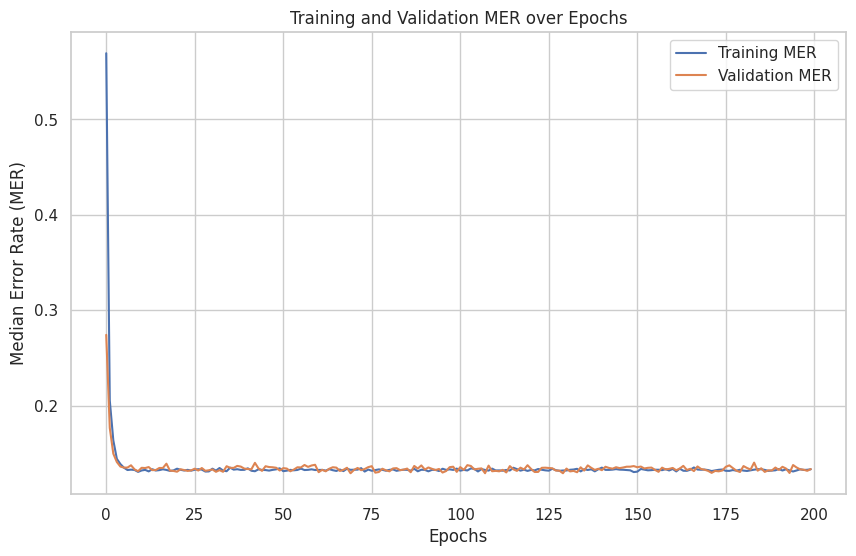

In [40]:
#TODO: Write code to plot the training and vadliation errors (MER) over epochs

def plot_errors(train_errors, val_errors):
    plt.figure(figsize=(10, 6))
    plt.plot(train_errors, label="Training MER")
    plt.plot(val_errors, label="Validation MER")
    plt.xlabel("Epochs")
    plt.ylabel("Median Error Rate (MER)")
    plt.title("Training and Validation MER over Epochs")
    plt.legend()
    plt.show()

# Call the plotting function
plot_errors(training_errors, validation_errors)

---
## Build the Multi-layer Perceptron Base Model

In the following, we build a multi-layer perception model with 2 hidden layers of sizes 256 and 128, respectively and ReLu activations.

In [41]:
# Build a feed-forward network
import torch.nn as nn
model = nn.Sequential(nn.Linear(train_features.shape[1], 256),
                      nn.ReLU(),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Linear(128,1))

Let's print out the model achitecture.

In [42]:
model

Sequential(
  (0): Linear(in_features=105, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=1, bias=True)
)

In [43]:
# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [44]:
import torch.optim as optim
import numpy as np

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize lists to store per-epoch training and validation errors
mlp_training_errors = []
mlp_validation_errors = []

# Define the number of epochs
epochs = 200

#TODO: write code to train the MLP network and save training and validation error.

for epoch in range(epochs):
    model.train()  # Set model to training mode

    epoch_train_error_rates = []

    # Training loop
    for features, labels in train_loader:
        # Move data to device
        features, labels = features.to(device), labels.to(device)

        # Forward pass
        outputs = model(features)

        # Compute training loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate relative error rate for MER
        error_rate = torch.abs((outputs - labels) / labels)
        epoch_train_error_rates.extend(error_rate.cpu().detach().numpy())

    # Calculate and store median error rate for training
    median_train_error = np.median(epoch_train_error_rates)
    mlp_training_errors.append(median_train_error)

    # Validation step
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        epoch_val_error_rates = []
        for features, labels in valid_loader:
            # Move data to device
            features, labels = features.to(device), labels.to(device)

            # Forward pass
            outputs = model(features)

            # Calculate relative error rate for validation MER
            error_rate = torch.abs((outputs - labels) / labels)
            epoch_val_error_rates.extend(error_rate.cpu().numpy())

        # Calculate and store median error rate for validation
        median_val_error = np.median(epoch_val_error_rates)
        mlp_validation_errors.append(median_val_error)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Train MER: {median_train_error:.4f}, Validation MER: {median_val_error:.4f}")


Epoch [10/200], Train MER: 0.1041, Validation MER: 0.1034
Epoch [20/200], Train MER: 0.0960, Validation MER: 0.0946
Epoch [30/200], Train MER: 0.0909, Validation MER: 0.1010
Epoch [40/200], Train MER: 0.0888, Validation MER: 0.1025
Epoch [50/200], Train MER: 0.0817, Validation MER: 0.0980
Epoch [60/200], Train MER: 0.0807, Validation MER: 0.1012
Epoch [70/200], Train MER: 0.0734, Validation MER: 0.1011
Epoch [80/200], Train MER: 0.0718, Validation MER: 0.1060
Epoch [90/200], Train MER: 0.0695, Validation MER: 0.1006
Epoch [100/200], Train MER: 0.0648, Validation MER: 0.1046
Epoch [110/200], Train MER: 0.0633, Validation MER: 0.0949
Epoch [120/200], Train MER: 0.0615, Validation MER: 0.0961
Epoch [130/200], Train MER: 0.0594, Validation MER: 0.1044
Epoch [140/200], Train MER: 0.0562, Validation MER: 0.1004
Epoch [150/200], Train MER: 0.0579, Validation MER: 0.1058
Epoch [160/200], Train MER: 0.0573, Validation MER: 0.1002
Epoch [170/200], Train MER: 0.0570, Validation MER: 0.1030
Epoch 

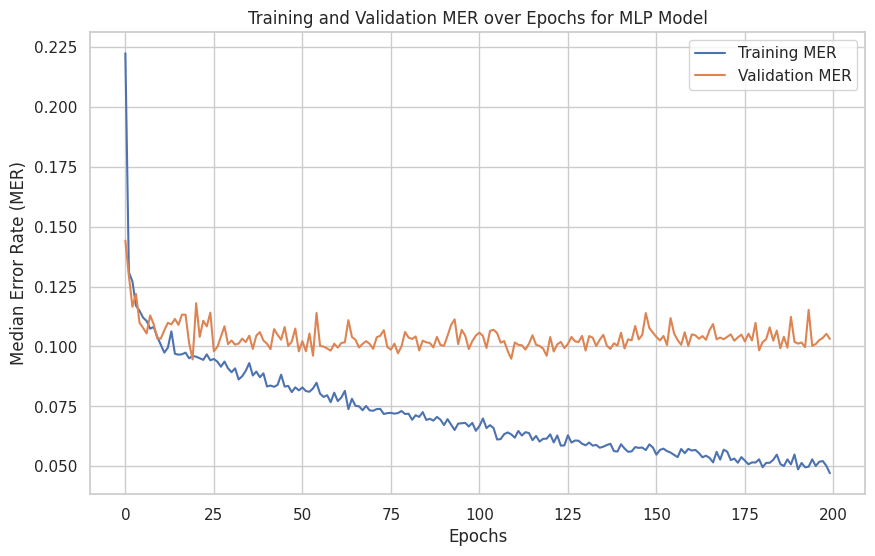

In [45]:
#TODO: Write code to plot the training and validation error (MER) over epochs
def plot_mlp_errors(train_errors, val_errors):
    plt.figure(figsize=(10, 6))
    plt.plot(train_errors, label="Training MER")
    plt.plot(val_errors, label="Validation MER")
    plt.xlabel("Epochs")
    plt.ylabel("Median Error Rate (MER)")
    plt.title("Training and Validation MER over Epochs for MLP Model")
    plt.legend()
    plt.show()

# Call the plotting function
plot_mlp_errors(mlp_training_errors, mlp_validation_errors)

---
## Change network architecture


In the following, build a MLP with 4 hidden layer of sizes 512, 256, 128, 64, respectively.  

In [46]:
#TODO: building a MLP with 4 hidden layer of sizes 512, 256, 128, 64,

import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

model = nn.Sequential(
    nn.Linear(train_features.shape[1], 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1)  # Output layer
)

# Print model architecture to confirm
print("Updated MLP Model Architecture with 4 Hidden Layers:")
print(model)

# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize lists to store per-epoch training and validation errors
training_errors = []
validation_errors = []

# Define the number of epochs
epochs = 200

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode

    epoch_train_error_rates = []

    # Training loop
    for features, labels in train_loader:
        # Move data to device
        features, labels = features.to(device), labels.to(device)

        # Forward pass
        outputs = model(features)

        # Compute training loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate relative error rate for MER
        error_rate = torch.abs((outputs - labels) / labels)
        epoch_train_error_rates.extend(error_rate.cpu().detach().numpy())

    # Calculate and store median error rate for training
    median_train_error = np.median(epoch_train_error_rates)
    training_errors.append(median_train_error)

    # Validation step
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        epoch_val_error_rates = []
        for features, labels in valid_loader:
            # Move data to device
            features, labels = features.to(device), labels.to(device)

            # Forward pass
            outputs = model(features)

            # Calculate relative error rate for validation MER
            error_rate = torch.abs((outputs - labels) / labels)
            epoch_val_error_rates.extend(error_rate.cpu().numpy())

        # Calculate and store median error rate for validation
        median_val_error = np.median(epoch_val_error_rates)
        validation_errors.append(median_val_error)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch [{epoch + 1}/{epochs}], Train MER: {median_train_error:.4f}, Validation MER: {median_val_error:.4f}")

Updated MLP Model Architecture with 4 Hidden Layers:
Sequential(
  (0): Linear(in_features=105, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Linear(in_features=64, out_features=1, bias=True)
)
Epoch [10/200], Train MER: 0.1099, Validation MER: 0.1033
Epoch [20/200], Train MER: 0.0931, Validation MER: 0.1460
Epoch [30/200], Train MER: 0.0855, Validation MER: 0.1080
Epoch [40/200], Train MER: 0.0777, Validation MER: 0.1057
Epoch [50/200], Train MER: 0.0687, Validation MER: 0.1054
Epoch [60/200], Train MER: 0.0713, Validation MER: 0.1014
Epoch [70/200], Train MER: 0.0634, Validation MER: 0.0983
Epoch [80/200], Train MER: 0.0577, Validation MER: 0.0997
Epoch [90/200], Train MER: 0.0595, Validation MER: 0.0954
Epoch [100/200], Train MER: 0.0537, Validation MER: 0.0998


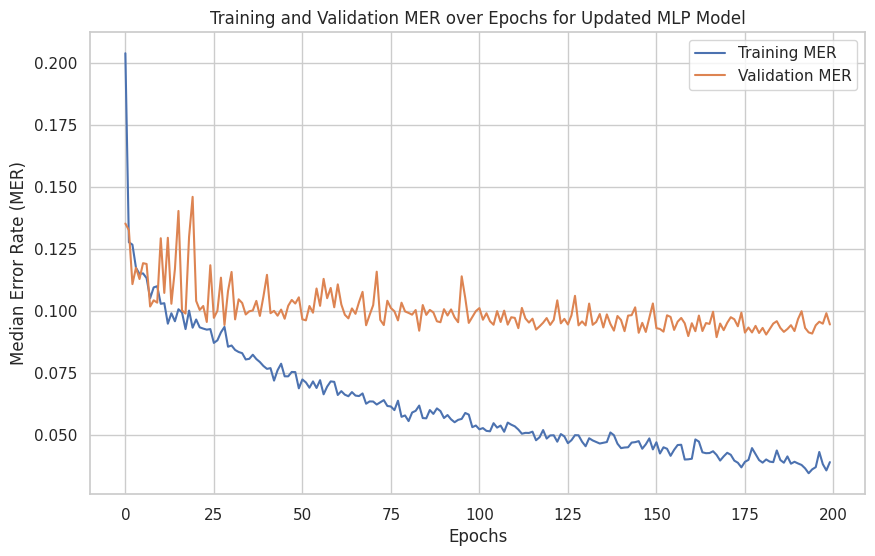

In [47]:
#TODO: plot the training and validation error (MER) over epochs
def plot_errors(train_errors, val_errors):
    plt.figure(figsize=(10, 6))
    plt.plot(train_errors, label="Training MER")
    plt.plot(val_errors, label="Validation MER")
    plt.xlabel("Epochs")
    plt.ylabel("Median Error Rate (MER)")
    plt.title("Training and Validation MER over Epochs for Updated MLP Model")
    plt.legend()
    plt.show()

# Call the plotting function
plot_errors(training_errors, validation_errors)

In [48]:
def save_model(model, optimizer, validation_errors):
    # Define the path to save the best model checkpoint
    checkpoint_path = "checkpoint.pth"

    # Save the model state and relevant information
    torch.save({
        'model_state_dict': model.state_dict(),   # Save model weights
        'optimizer_state_dict': optimizer.state_dict(),  # Save optimizer state for potential continued training
        'hyperparameters': {
            'hidden_layers': [512, 256, 128, 64],  # Update this to reflect the specific layers used
            'learning_rate': 0.001,
            'dropout_probability': 0.2
        },
        'validation_error': min(validation_errors)  # Record the best validation error achieved
    }, checkpoint_path)

    # print(f"Model successfully saved to {checkpoint_path}")

---
## Add norm regularization

In the following, use the norm regularization to retrain the above MLP.

Updated MLP Model Architecture with 3 Hidden Layers:
Sequential(
  (0): Linear(in_features=105, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=1, bias=True)
)
0 0.14680402
2 0.114553794
3 0.109578386
5 0.1083161
6 0.105848774
8 0.10420068
Epoch [10/100], Train MER: 0.1060, Validation MER: 0.1271
13 0.0994961
14 0.09744501
16 0.09696613
Epoch [20/100], Train MER: 0.0929, Validation MER: 0.1084
Epoch [30/100], Train MER: 0.0907, Validation MER: 0.1004
Epoch [40/100], Train MER: 0.0862, Validation MER: 0.1239
Epoch [50/100], Train MER: 0.0795, Validation MER: 0.1052
53 0.09427555
Epoch [60/100], Train MER: 0.0717, Validation MER: 0.0984
Epoch [70/100], Train MER: 0.0744, Validation MER: 0.1043
79 0.09057551
Epoch [80/100], Train MER: 0.0674, Validation MER: 0.0906
Epoch [90/100], Train MER: 0.0659, Valid

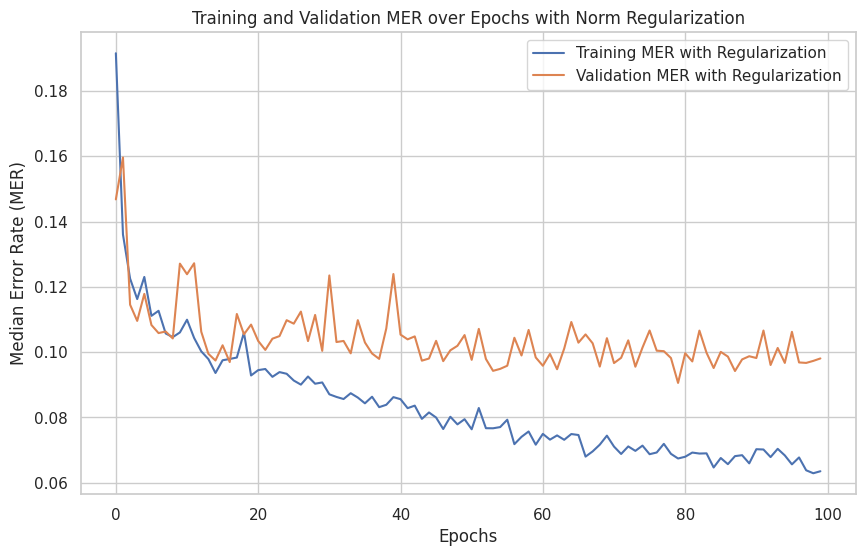

In [49]:
#TODO: plot the training and validation error (MER) over epochs after using norm regularization

model = nn.Sequential(
    nn.Linear(train_features.shape[1], 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 1)  # Output layer
)

# Print model architecture to confirm
print("Updated MLP Model Architecture with 3 Hidden Layers:")
print(model)

# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()

# Define the optimizer with L2 regularization (weight decay)
weight_decay = 0.001  # Adjust this value based on experimentation
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)

# Initialize lists to store per-epoch training and validation errors
training_errors = []
validation_errors = []

# Define the number of epochs
epochs = 100

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode

    epoch_train_error_rates = []

    # Training loop
    for features, labels in train_loader:
        # Move data to device
        features, labels = features.to(device), labels.to(device)

        # Forward pass
        outputs = model(features)

        # Compute training loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate relative error rate for MER
        error_rate = torch.abs((outputs - labels) / labels)
        epoch_train_error_rates.extend(error_rate.cpu().detach().numpy())

    # Calculate and store median error rate for training
    median_train_error = np.median(epoch_train_error_rates)
    training_errors.append(median_train_error)

    # Validation step
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        epoch_val_error_rates = []
        for features, labels in valid_loader:
            # Move data to device
            features, labels = features.to(device), labels.to(device)

            # Forward pass
            outputs = model(features)

            # Calculate relative error rate for validation MER
            error_rate = torch.abs((outputs - labels) / labels)
            epoch_val_error_rates.extend(error_rate.cpu().numpy())

        # Calculate and store median error rate for validation
        median_val_error = np.median(epoch_val_error_rates)
        validation_errors.append(median_val_error)

        if len(validation_errors) == 0 or median_val_error <= np.min(validation_errors):
            print(epoch, median_val_error)
            save_model(model, optimizer, validation_errors)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch [{epoch + 1}/{epochs}], Train MER: {median_train_error:.4f}, Validation MER: {median_val_error:.4f}")

def plot_errors_with_regularization(train_errors, val_errors):
    plt.figure(figsize=(10, 6))
    plt.plot(train_errors, label="Training MER with Regularization")
    plt.plot(val_errors, label="Validation MER with Regularization")
    plt.xlabel("Epochs")
    plt.ylabel("Median Error Rate (MER)")
    plt.title("Training and Validation MER over Epochs with Norm Regularization")
    plt.legend()
    plt.show()

# Call the plotting function
plot_errors_with_regularization(training_errors, validation_errors)

---
## Add dropout layer

In the following, add dropout layer to the above MLP.


In [50]:
def save_model(model, optimizer, validation_errors):
    # Define the path to save the best model checkpoint
    checkpoint_path = "checkpoint.pth"

    # Save the model state and relevant information
    torch.save({
        'model_state_dict': model.state_dict(),   # Save model weights
        'optimizer_state_dict': optimizer.state_dict(),  # Save optimizer state for potential continued training
        'hyperparameters': {
            'hidden_layers': [512, 256, 128, 64],  # Update this to reflect the specific layers used
            'learning_rate': 0.001,
            'dropout_probability': 0.2
        },
        'validation_error': min(validation_errors)  # Record the best validation error achieved
    }, checkpoint_path)

    print(f"Model successfully saved to {checkpoint_path}")

In [51]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

0 0.1399223
Model successfully saved to checkpoint.pth
1 0.1363771
Model successfully saved to checkpoint.pth
2 0.13475673
Model successfully saved to checkpoint.pth
4 0.1205296
Model successfully saved to checkpoint.pth
5 0.1157814
Model successfully saved to checkpoint.pth
6 0.11250778
Model successfully saved to checkpoint.pth
Epoch [10/150], Train MER: 0.1424, Validation MER: 0.1204
10 0.11170793
Model successfully saved to checkpoint.pth
12 0.10460981
Model successfully saved to checkpoint.pth
17 0.10125873
Model successfully saved to checkpoint.pth
Epoch [20/150], Train MER: 0.1246, Validation MER: 0.1046
20 0.096645184
Model successfully saved to checkpoint.pth
24 0.09178095
Model successfully saved to checkpoint.pth
Epoch [30/150], Train MER: 0.1193, Validation MER: 0.1049
34 0.09044896
Model successfully saved to checkpoint.pth
Epoch [40/150], Train MER: 0.1123, Validation MER: 0.0925
Epoch [50/150], Train MER: 0.1066, Validation MER: 0.0940
Epoch [60/150], Train MER: 0.1042, 

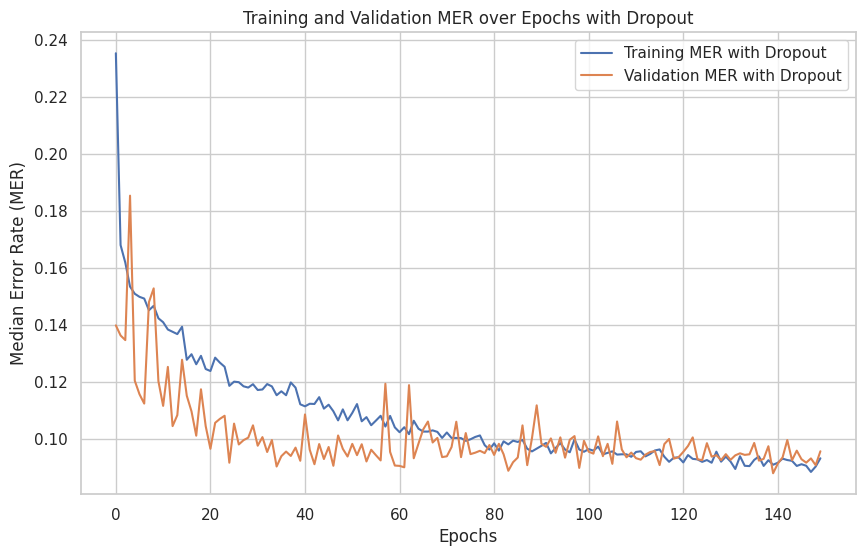

In [52]:
#TODO: plot the training and validation error (MER) over epochs after using norm regularization
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the model architecture with dropout layers added after each hidden layer
dropout_prob = 0.2
model = nn.Sequential(
    nn.Linear(train_features.shape[1], 512),
    nn.ReLU(),
    nn.Dropout(dropout_prob),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(dropout_prob),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(dropout_prob),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(dropout_prob),
    nn.Linear(64, 1)  # Output layer
)

# Move model to GPU if available
model = model.to(device)


# Define loss function and optimizer
criterion = nn.MSELoss()

# Define the optimizer with L2 regularization (weight decay)
weight_decay = 0.001  # Adjust this value based on experimentation
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)

# Initialize lists to store per-epoch training and validation errors
training_errors = []
validation_errors = []

# Define the number of epochs
epochs = 150

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode

    epoch_train_error_rates = []

    # Training loop
    for features, labels in train_loader:
        # Move data to device
        features, labels = features.to(device), labels.to(device)

        # Forward pass
        outputs = model(features)

        # Compute training loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate relative error rate for MER
        error_rate = torch.abs((outputs - labels) / labels)
        epoch_train_error_rates.extend(error_rate.cpu().detach().numpy())

    # Calculate and store median error rate for training
    median_train_error = np.median(epoch_train_error_rates)
    training_errors.append(median_train_error)

    # Validation step
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        epoch_val_error_rates = []
        for features, labels in valid_loader:
            # Move data to device
            features, labels = features.to(device), labels.to(device)

            # Forward pass
            outputs = model(features)

            # Calculate relative error rate for validation MER
            error_rate = torch.abs((outputs - labels) / labels)
            epoch_val_error_rates.extend(error_rate.cpu().numpy())

        # Calculate and store median error rate for validation
        median_val_error = np.median(epoch_val_error_rates)
        validation_errors.append(median_val_error)

        if len(validation_errors) == 0 or median_val_error <= np.min(validation_errors):
            print(epoch, median_val_error)
            save_model(model, optimizer, validation_errors)

        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
        # if epoch == epochs - 1:
            print(f"Epoch [{epoch + 1}/{epochs}], Train MER: {median_train_error:.4f}, Validation MER: {median_val_error:.4f}")

# Plotting function for errors after adding dropout
def plot_errors_with_dropout(train_errors, val_errors):
    plt.figure(figsize=(10, 6))
    plt.plot(train_errors, label="Training MER with Dropout")
    plt.plot(val_errors, label="Validation MER with Dropout")
    plt.xlabel("Epochs")
    plt.ylabel("Median Error Rate (MER)")
    plt.title("Training and Validation MER over Epochs with Dropout")
    plt.legend()
    plt.show()

# Call the plotting function
plot_errors_with_dropout(training_errors, validation_errors)

## Some other model variations

**You're more than welcome to try some other model varations (e.g. different number of hidden layers, hidden neurons, learning rate, etc) to achieve lower valid error. Include a table listing all the model hyperparameters that you have tried with the corresponding validation errors that you found.**

In [53]:
# Function to train and evaluate model with given hyperparameters
def train_model_with_hyperparams(hidden_neurons, lr, dropout_prob, weight_decay):
    layers = []
    input_dim = train_features.shape[1]

    # Create model structure based on specified hidden_neurons and dropout_prob
    for neurons in hidden_neurons:
        layers.append(nn.Linear(input_dim, neurons))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_prob))
        input_dim = neurons

    # Output layer
    layers.append(nn.Linear(input_dim, 1))
    model = nn.Sequential(*layers).to(device)

    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight,
                                          gain=nn.init.calculate_gain('relu'))
            # torch.nn.init.kaiming_uniform_(m.weight, a=0, mode='fan_in',
                                          #  nonlinearity='leaky_relu')
            m.bias.data.fill_(0.0)

    model.apply(init_weights)

    # Define loss function and optimizer (with L2 regularization)
    criterion = nn.L1Loss()
    # optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=0.9)


    # Training the model
    training_errors, validation_errors = [], []
    for epoch in range(300):  # Use fewer epochs for quicker testing
        model.train()
        epoch_train_error_rates = []
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            error_rate = torch.abs((outputs - labels) / labels)
            epoch_train_error_rates.extend(error_rate.cpu().detach().numpy())
        median_train_error = np.median(epoch_train_error_rates)
        training_errors.append(median_train_error)

        # Validation phase
        model.eval()
        epoch_val_error_rates = []
        with torch.no_grad():
            for features, labels in valid_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                error_rate = torch.abs((outputs - labels) / labels)
                epoch_val_error_rates.extend(error_rate.cpu().numpy())
        validation_errors.append(np.median(epoch_val_error_rates))

    return min(validation_errors)


# Define hyperparameter combinations
hyperparams_list = [
    {"hidden_neurons": [512, 256, 128, 64], "lr": 0.003, "dropout_prob": 0.1, "weight_decay": 0.001},
    {"hidden_neurons": [512, 256, 128, 64], "lr": 0.001, "dropout_prob": 0.1, "weight_decay": 0.001},
    {"hidden_neurons": [512, 256, 128, 64], "lr": 0.001, "dropout_prob": 0.2, "weight_decay": 0.001},
    {"hidden_neurons": [512, 256, 128, 64], "lr": 0.001, "dropout_prob": 0.1, "weight_decay": 0.002},
    {"hidden_neurons": [512, 256, 128, 64], "lr": 0.0005, "dropout_prob": 0.2, "weight_decay": 0.001},
    {"hidden_neurons": [256, 128, 64], "lr": 0.003, "dropout_prob": 0.1, "weight_decay": 0.001},
    {"hidden_neurons": [256, 128, 64], "lr": 0.001, "dropout_prob": 0.1, "weight_decay": 0.001},
    {"hidden_neurons": [256, 128, 64], "lr": 0.001, "dropout_prob": 0.2, "weight_decay": 0.001},
    {"hidden_neurons": [256, 128, 64], "lr": 0.001, "dropout_prob": 0.1, "weight_decay": 0.002},
    {"hidden_neurons": [256, 128, 64], "lr": 0.0005, "dropout_prob": 0.2, "weight_decay": 0.001},
]

# Store results
results = []
for i, params in enumerate(hyperparams_list):
    print(f"Training model {i+1} with params: {params}")
    min_val_error = train_model_with_hyperparams(
        hidden_neurons=params["hidden_neurons"],
        lr=params["lr"],
        dropout_prob=params["dropout_prob"],
        weight_decay=params["weight_decay"]
    )
    results.append({
        "Model": i+1,
        "Hidden Neurons": params["hidden_neurons"],
        "Learning Rate": params["lr"],
        "Dropout Probability": params["dropout_prob"],
        "Weight Decay": params["weight_decay"],
        "Min Validation MER": min_val_error
    })


import pandas as pd
results_df = pd.DataFrame(results)
results_df


Training model 1 with params: {'hidden_neurons': [512, 256, 128, 64], 'lr': 0.003, 'dropout_prob': 0.1, 'weight_decay': 0.001}
Training model 2 with params: {'hidden_neurons': [512, 256, 128, 64], 'lr': 0.001, 'dropout_prob': 0.1, 'weight_decay': 0.001}
Training model 3 with params: {'hidden_neurons': [512, 256, 128, 64], 'lr': 0.001, 'dropout_prob': 0.2, 'weight_decay': 0.001}
Training model 4 with params: {'hidden_neurons': [512, 256, 128, 64], 'lr': 0.001, 'dropout_prob': 0.1, 'weight_decay': 0.002}
Training model 5 with params: {'hidden_neurons': [512, 256, 128, 64], 'lr': 0.0005, 'dropout_prob': 0.2, 'weight_decay': 0.001}
Training model 6 with params: {'hidden_neurons': [256, 128, 64], 'lr': 0.003, 'dropout_prob': 0.1, 'weight_decay': 0.001}
Training model 7 with params: {'hidden_neurons': [256, 128, 64], 'lr': 0.001, 'dropout_prob': 0.1, 'weight_decay': 0.001}
Training model 8 with params: {'hidden_neurons': [256, 128, 64], 'lr': 0.001, 'dropout_prob': 0.2, 'weight_decay': 0.001

,Model,Hidden Neurons,Learning Rate,Dropout Probability,Weight Decay,Min Validation MER
0,1,"[512, 256, 128, 64]",0.0030,0.1,0.001,0.079328
1,2,"[512, 256, 128, 64]",0.0010,0.1,0.001,0.078984
2,3,"[512, 256, 128, 64]",0.0010,0.2,0.001,0.081088
3,4,"[512, 256, 128, 64]",0.0010,0.1,0.002,0.080180
4,5,"[512, 256, 128, 64]",0.0005,0.2,0.001,0.085762
5,6,"[256, 128, 64]",0.0030,0.1,0.001,0.080261
6,7,"[256, 128, 64]",0.0010,0.1,0.001,0.082627
7,8,"[256, 128, 64]",0.0010,0.2,0.001,0.081342
8,9,"[256, 128, 64]",0.0010,0.1,0.002,0.080132
9,10,"[256, 128, 64]",0.0005,0.2,0.001,0.083114


In [54]:
def save_model(model, optimizer, validation_errors, lr, dropout, layers):
    # Define the path to save the best model checkpoint
    checkpoint_path = "checkpoint.pth"

    # Save the model state and relevant information
    torch.save({
        'model_state_dict': model.state_dict(),   # Save model weights
        'optimizer_state_dict': optimizer.state_dict(),  # Save optimizer state for potential continued training
        'hyperparameters': {
            'hidden_layers': layers,  # Update this to reflect the specific layers used
            'learning_rate': lr,
            'dropout_probability': dropout
        },
        'validation_error': min(validation_errors)  # Record the best validation error achieved
    }, checkpoint_path)

    print(f"Model successfully saved to {checkpoint_path}")

0 0.21177833 0.15761471
Model successfully saved to checkpoint.pth
1 0.20378472 0.14132805
Model successfully saved to checkpoint.pth
2 0.18506181 0.13558105
Model successfully saved to checkpoint.pth
3 0.17355394 0.11661589
Model successfully saved to checkpoint.pth
5 0.16848351 0.112485796
Model successfully saved to checkpoint.pth
8 0.16293499 0.10549083
Model successfully saved to checkpoint.pth
Epoch [10/300], Train MER: 0.1157, Validation MER: 0.1152
11 0.1587472 0.100965396
Model successfully saved to checkpoint.pth
13 0.1571717 0.100692086
Model successfully saved to checkpoint.pth
14 0.158165 0.09894818
Model successfully saved to checkpoint.pth
17 0.15544663 0.094259046
Model successfully saved to checkpoint.pth
Epoch [20/300], Train MER: 0.1007, Validation MER: 0.0964
21 0.15268211 0.09141095
Model successfully saved to checkpoint.pth
25 0.1546282 0.09006031
Model successfully saved to checkpoint.pth
Epoch [30/300], Train MER: 0.0927, Validation MER: 0.0916
30 0.1510419 0.08

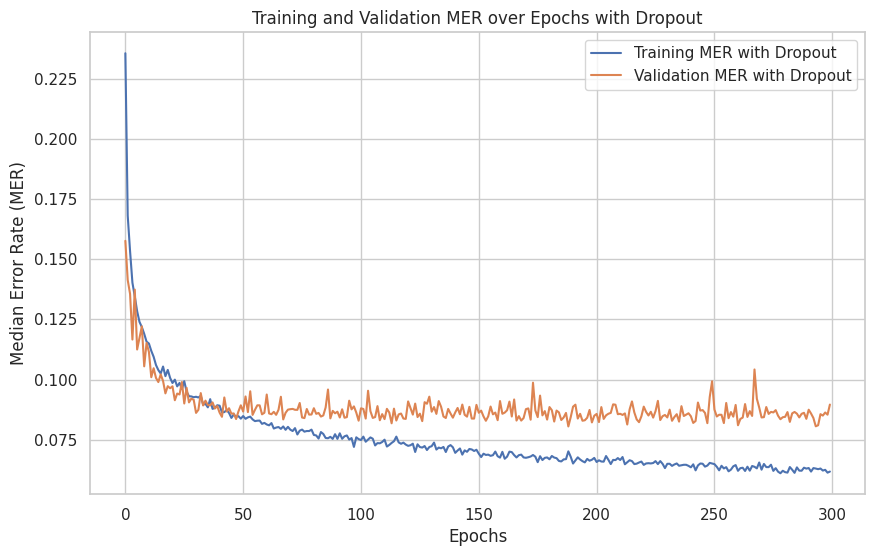

In [55]:
#TODO: plot the training and validation error (MER) over epochs after using norm regularization
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the model architecture with dropout layers added after each hidden layer
dropout_prob = 0.1
model = nn.Sequential(
    nn.Linear(train_features.shape[1], 512),
    nn.LeakyReLU(),
    nn.Dropout(dropout_prob),
    nn.Linear(512, 256),
    nn.LeakyReLU(),
    nn.Dropout(dropout_prob),
    nn.Linear(256, 128),
    nn.LeakyReLU(),
    nn.Dropout(dropout_prob),
    nn.Linear(128, 64),
    nn.LeakyReLU(),
    nn.Dropout(dropout_prob),
    nn.Linear(64, 1)  # Output layer
)

# Move model to GPU if available
model = model.to(device)

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight,
                                      gain=nn.init.calculate_gain('relu'))
        # torch.nn.init.kaiming_uniform_(m.weight, a=0, mode='fan_in',
                                      #  nonlinearity='leaky_relu')
        m.bias.data.fill_(0.0)

model.apply(init_weights)


# Define loss function and optimizer
criterion = nn.L1Loss()

# Define the optimizer with L2 regularization (weight decay)
weight_decay = 0.001  # Adjust this value based on experimentation
# optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=weight_decay)
optimizer = optim.SGD(model.parameters(), lr=0.003, weight_decay=weight_decay, momentum=0.9)

# Initialize lists to store per-epoch training and validation errors
training_errors = []
validation_errors = []
mean_validation_errors = []

# Define the number of epochs
epochs = 300

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode

    epoch_train_error_rates = []

    # Training loop
    for features, labels in train_loader:
        # Move data to device
        features, labels = features.to(device), labels.to(device)

        # Forward pass
        outputs = model(features)

        # Compute training loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate relative error rate for MER
        error_rate = torch.abs((outputs - labels) / labels)
        epoch_train_error_rates.extend(error_rate.cpu().detach().numpy())

    # Calculate and store median error rate for training
    median_train_error = np.median(epoch_train_error_rates)
    training_errors.append(median_train_error)

    # Validation step
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        epoch_val_error_rates = []
        for features, labels in valid_loader:
            # Move data to device
            features, labels = features.to(device), labels.to(device)

            # Forward pass
            outputs = model(features)

            # Calculate relative error rate for validation MER
            error_rate = torch.abs((outputs - labels) / labels)
            epoch_val_error_rates.extend(error_rate.cpu().numpy())

        # Calculate and store median error rate for validation
        median_val_error = np.median(epoch_val_error_rates)
        validation_errors.append(median_val_error)

        mean_val_error = np.mean(epoch_val_error_rates)
        mean_validation_errors.append(mean_val_error)

        if len(validation_errors) == 0 or median_val_error <= np.min(validation_errors):
            print(epoch, mean_val_error, median_val_error)
            save_model(model, optimizer, validation_errors, 0.003,
                       dropout_prob, [512, 256, 128, 64])

        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
        # if epoch == epochs - 1:
            print(f"Epoch [{epoch + 1}/{epochs}], Train MER: {median_train_error:.4f}, Validation MER: {median_val_error:.4f}")

# Plotting function for errors after adding dropout
def plot_errors_with_dropout(train_errors, val_errors):
    plt.figure(figsize=(10, 6))
    plt.plot(train_errors, label="Training MER with Dropout")
    plt.plot(val_errors, label="Validation MER with Dropout")
    plt.xlabel("Epochs")
    plt.ylabel("Median Error Rate (MER)")
    plt.title("Training and Validation MER over Epochs with Dropout")
    plt.legend()
    plt.show()

# Call the plotting function
plot_errors_with_dropout(training_errors, validation_errors)

---
## Save Model

Save a `checkpoint.pth` file containing all the necessary information to retrieve your best model and predictions. Remember submitting this file to Canvas siste.

Hint: Check out the `Lecture 4 - Saving and Loading Models.ipynb` on Canvas if you do not know how to save model.

In [56]:
def save_model(model, optimizer, validation_errors, lr, dropout, layers):
    # Define the path to save the best model checkpoint
    checkpoint_path = "checkpoint.pth"

    # Save the model state and relevant information
    torch.save({
        'model_state_dict': model.state_dict(),   # Save model weights
        'optimizer_state_dict': optimizer.state_dict(),  # Save optimizer state for potential continued training
        'hyperparameters': {
            'hidden_layers': layers,  # Update this to reflect the specific layers used
            'learning_rate': lr,
            'dropout_probability': dropout
        },
        'validation_error': min(validation_errors)  # Record the best validation error achieved
    }, checkpoint_path)

    print(f"Model successfully saved to {checkpoint_path}")

---
## Inference on test data

After the model is trained, we can use it for inference.

In [57]:
## TODO: Load your best model from your saved checkpoint.pth file.
checkpoint = torch.load("checkpoint.pth")

# Rebuild the model architecture using saved hyperparameters (assuming 4 hidden layers)
model = nn.Sequential(
    nn.Linear(train_features.shape[1], checkpoint['hyperparameters']['hidden_layers'][0]),
    nn.ReLU(),
    nn.Dropout(checkpoint['hyperparameters']['dropout_probability']),
    nn.Linear(checkpoint['hyperparameters']['hidden_layers'][0], checkpoint['hyperparameters']['hidden_layers'][1]),
    nn.ReLU(),
    nn.Dropout(checkpoint['hyperparameters']['dropout_probability']),
    nn.Linear(checkpoint['hyperparameters']['hidden_layers'][1], checkpoint['hyperparameters']['hidden_layers'][2]),
    nn.ReLU(),
    nn.Dropout(checkpoint['hyperparameters']['dropout_probability']),
    nn.Linear(checkpoint['hyperparameters']['hidden_layers'][2], checkpoint['hyperparameters']['hidden_layers'][3]),
    nn.ReLU(),
    nn.Dropout(checkpoint['hyperparameters']['dropout_probability']),
    nn.Linear(checkpoint['hyperparameters']['hidden_layers'][3], 1)  # Output layer
)


# Load model state
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()  # Set model to evaluation mode
print("Best model loaded successfully.")

Best model loaded successfully.


<ipython-input-57-a57807519536>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("checkpoint.pth")


In [58]:
#TODO: write the code to generate predicted sale prices for test data

# Set the model to evaluation mode for inference
model.eval()

# Generate predicted sale prices for test data
with torch.no_grad():
    # Move test features to device
    test_features = test_features.to(device)

    # Perform inference to get predictions
    predictions = model(test_features)

    # Convert predictions back to original scale by multiplying with the normalization factor
    predictions = predictions.cpu().numpy() * normalization_factor

In [59]:
#TODO: save the predicted sale prices into submission_csv

# Prepare the submission DataFrame
submission_df = pd.DataFrame({
    "ID": test_ID,  # Assuming test_ID is available from earlier steps where we dropped 'ID' column
    "SALE_PRICE": predictions.flatten()  # Flatten predictions to a 1D array
})

# Save to CSV
submission_df.to_csv("submission.csv", index=False)
print("Predictions saved to submission.csv")

Predictions saved to submission.csv


Now, we can submit our predictions on Kaggle and see how they compare with the actual house prices (labels) on the test set.

- Log in to the Kaggle website and visit the house price prediction competition page.

- Click the “Submit Predictions”.

- Click the “Browse Files” button in the dashed box at the bottom of the page and select the prediction file you wish to upload.

- Click the “Submit” button at the bottom of the page to view your results.

 **Include your best test error shown on Kaggle in your case report!**

---
## Evaluate the profit of iBuyer business model


In class, we have dicussed the iBuyer business model and its opportunities and risks. In the following analysis, imagine you work in a consulting firm and would like to investigate the profitability of the iBuyer business model.

You have taken the Mordern Analytics course and remembered that Prof. X advocated the data-driven approach in business decision making. Thus, you would like to perform analysis based on model and data.

Note that since we do not know the true sale prices in the future (like test data), we need to conduct the analysis based on the historical data (train or validation data). Previously, you have already trained a multilayer perceptron model using the train data. Now, let's evaluate the profit of iBuyer business model based on the predicted prices on the **validation data**.

Let's first compute the predicted prices on the valid data.

In [60]:
## TODO: Load your best model from your saved checkpoint.pth file.
checkpoint = torch.load("checkpoint.pth")

# Rebuild the model architecture using saved hyperparameters (assuming 4 hidden layers)
model = nn.Sequential(
    nn.Linear(train_features.shape[1], checkpoint['hyperparameters']['hidden_layers'][0]),
    nn.ReLU(),
    nn.Dropout(checkpoint['hyperparameters']['dropout_probability']),
    nn.Linear(checkpoint['hyperparameters']['hidden_layers'][0], checkpoint['hyperparameters']['hidden_layers'][1]),
    nn.ReLU(),
    nn.Dropout(checkpoint['hyperparameters']['dropout_probability']),
    nn.Linear(checkpoint['hyperparameters']['hidden_layers'][1], checkpoint['hyperparameters']['hidden_layers'][2]),
    nn.ReLU(),
    nn.Dropout(checkpoint['hyperparameters']['dropout_probability']),
    nn.Linear(checkpoint['hyperparameters']['hidden_layers'][2], checkpoint['hyperparameters']['hidden_layers'][3]),
    nn.ReLU(),
    nn.Dropout(checkpoint['hyperparameters']['dropout_probability']),
    nn.Linear(checkpoint['hyperparameters']['hidden_layers'][3], 1)  # Output layer
)

# Load model state
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()  # Set model to evaluation mode
print("Best model loaded successfully.")

Best model loaded successfully.


<ipython-input-60-8c8bd9ad881f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("checkpoint.pth")


In [61]:
## TODO: compute the predicted prices on valid data using your best model
with torch.no_grad():
    # Move validation features to the same device as the model
    valid_features = valid_features.to(device)

    # Generate predictions
    valid_predictions = model(valid_features)

    # Scale predictions back to original price scale
    valid_predictions = valid_predictions.cpu().numpy() * normalization_factor

# Convert actual validation labels back to the original scale
actual_prices = valid_labels.cpu().numpy() * normalization_factor

In [62]:
actual_prices[:5]

array([[ 566821.00296021],
       [ 590000.00953674],
       [ 254999.99523163],
       [ 317000.00762939],
       [1469999.98092651]])

In [63]:
valid_labels[:5]

tensor([[ 5.6682],
        [ 5.9000],
        [ 2.5500],
        [ 3.1700],
        [14.7000]])

Compute the signed error rates (without taking the absolute value sign), that is

$$
\text{Signed Error Rate} = \frac{\text{Predicted Price}-\text{Actual Price}}{\text{Actual Price}}
$$
We will call signed error rate as prediction error henceafter.

In [64]:
## TODO: compute the signed error rates (henceafter called prediction errors)

prediction_errors = (valid_predictions - actual_prices) / actual_prices

# Display some basic statistics on prediction errors for insight
import numpy as np

print(f"Mean Prediction Error: {np.mean(prediction_errors):.4f}")
print(f"Median Prediction Error: {np.median(prediction_errors):.4f}")
print(f"Std Dev of Prediction Error: {np.std(prediction_errors):.4f}")

Mean Prediction Error: 0.0422
Median Prediction Error: 0.0064
Std Dev of Prediction Error: 0.2641


### Analysis and visualization of valid errors

Let's plot the histogram of prediction errors.

**Question 1**: what is the bias of the prediction errors? Include the histogram of prediction errors and the bias in your report.

(array([4.700e+01, 1.095e+03, 1.034e+03, 9.700e+01, 1.600e+01, 1.200e+01,
        7.000e+00, 4.000e+00, 1.000e+00, 4.000e+00]),
 array([-0.70330576, -0.34948631,  0.00433313,  0.35815258,  0.71197202,
         1.06579147,  1.41961091,  1.77343036,  2.12724981,  2.48106925,
         2.8348887 ]),
 <BarContainer object of 10 artists>)

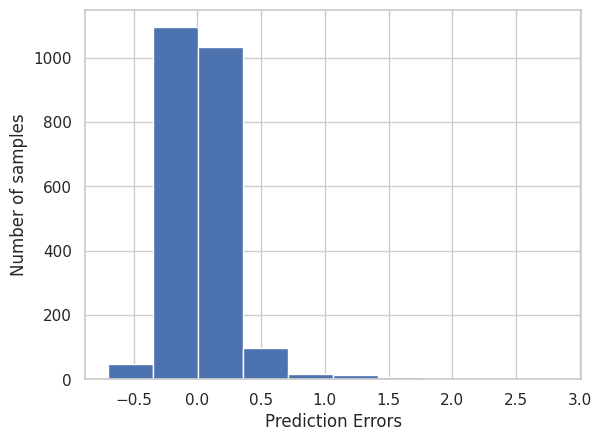

In [65]:
import matplotlib.pyplot as plt
plt.xlabel("Prediction Errors")
plt.ylabel("Number of samples")
plt.hist(prediction_errors)

### Profit Analysis

In the following profit analysis, we assume the iBuyer will make an offer to every property in the valid data based on their predicted price $PP$. We assume the iBuyer decides the offer price $OP$ according to
$$
OP = \frac{PP}{1+\alpha},
$$
where $\alpha$ is the (targted) profit margin of the iBuyer.
Here we assume the profit margin has already taken into consideration the commission fee charged by the iBuyer
and various costs associated such as transaction cost, administration cost, and holding cost. Note that the commission fee charged by Zillow is often around $7.5\%$ and Zillow may charge additional repair costs after home inspection. Thus we take $\alpha=12\%$ in this case study.

We further assume that the iBuyer can resell the property at the same
price as the broker in the future once the property is bought. In other words, the resell price is equal to the sale price in the valid data. This assumption may not be exactly true in practice and the iBuyer may sell the house at either a higher or lower price depending on the market trend. But our conclusion will not change too much.

Based on the above two assumptions, we can now determine the percentage profit
for a property bought by the iBuyer as
$$
\frac{SP- OP}{OP}.
$$
We use the percentage profit instead of the absolute profit because the iBuyer cannot hope to purchase all houses in the market. Therefore, the percentage profit is a better measure of the profitability of the iBuyer business model.
 The aim of the iBuyer in this simplified setting is to purchase properties for less money than they are sold for, to generate a profit.

In [66]:
profit_margin = 0.12

**Question 2**: Consider the hypothetical scenario where the offers are all accepted regardless of their values,
what is the average percentage profit? Do you see a big difference compared to the profit margin $\alpha$? Include your answers in the report.

In [67]:
op = valid_predictions / (1 + profit_margin)
np.mean((actual_prices - op) / op)

0.12463234586401369

**Offer Acceptance Rule**


However, not every offer will be accepted by the home owner. Given an offer price, whether the homeowner accepts it
depends on the homeowner's perceived valuation. For the current dataset, we lack enough data to determine the homeowner's perceived valuation of the property. However, the actual sale price in the valid data serves as a reasonable proxy of the homeowner's perceived valuation. Therefore, we assume that the home owner will accept the offer, if
$$
OP> (1-\beta) SP,
$$
where $\beta$ is a discounting factor. Here the discounting factor captures the commission fee charged
by the conventional realtors which is around 6%, as well as the convenience factor that models
how much the homeowner values the quick transaction services of the iBuyer over the conventional
relator. We assume $\beta = 10\%$ in this case.

**Question 3**: Based on the sale price in the valid data and the acceptance rule, what is the mean percentage profit among all accepted offers? Do you see a big difference compared to the targeted profit margin $\alpha$?  Include your answers in your report.  

In [68]:
bought = op > (1 - 0.1) * actual_prices
np.mean(((actual_prices - op) / op)[bought])

-0.02658745839582321

Let's plot the histogram of the prediction errors for those properties whose home owners accepted the offer.

**Question 4**: What is the bias of the prediction errors when restricting to those properties whose owners accepted the offer? Based on the histogram and bias, can you explain your answers to Question 3?

0.18974770560420576


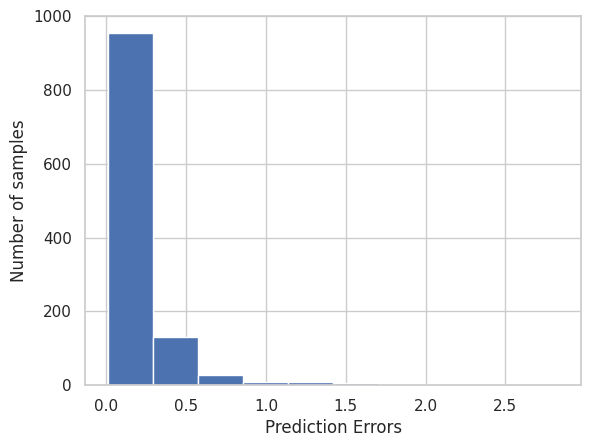

In [69]:
plt.xlabel("Prediction Errors")
plt.ylabel("Number of samples")
plt.hist(prediction_errors[bought])
print(np.mean(prediction_errors[bought]))